In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker


def get_state(ratio, q1, q3, iqr) -> str:
    if ratio < q1 - 1.5 * iqr:
        return 'loss'
    if ratio > q3 + 1.5 * iqr:
        return  'gain'
    return 'neutral'


def get_mappability(map_data: pd.DataFrame, row: pd.Series) -> float:
    chrom = row['chrom']
    chrom_start = row['chromStart']
    chrom_end  = row['chromEnd']
    t_map = map_data.query('(chrom == @chrom) & (chromStart <= @chrom_start) & (chromEnd >= @chrom_end)')['mappability']
    return float(t_map.round(2))


def get_target_quality(row: pd.Series) -> str:
    is_dispersion_high = row['mad/median'] >= 0.4
    is_mappability_bad = row['mappability'] < 0.76
    is_low_rd = row['median'] < 25
    if is_low_rd:
        return 'low baseline read-depth'
    if is_mappability_bad and is_mappability_bad:
        return 'poor map & high var'
    if is_mappability_bad:
        return 'poor mappability'
    if is_dispersion_high:
        return 'high variability'
    return 'stable'


def plot_gene(selected_gene: str, nrr_table: pd.DataFrame, map_table: pd.DataFrame,
              q1: float, q3: float, iqr: float) -> None:
    selected = nrr_table[nrr_table['gene'] == selected_gene].copy()
    selected['mappability'] = selected.apply(lambda row: get_mappability(map_table, row), axis=1)
    selected['copy state'] = selected['ratio'].apply(
        lambda r: get_state(r, q1, q3, iqr))
    selected['target quality'] = selected.apply(lambda row: get_target_quality(row), axis=1)
    selected['x'] = [f'T{i}' for i in range(1, len(selected) + 1)]
    selected['2x ratio'] = selected['ratio'].round(1) * 2

    with sns.axes_style('darkgrid'):
        if len(selected) > 18:
            plt.figure(figsize=(12 ,4))

        palette = {'neutral': 'royalblue',
                   'loss': 'orangered',
                   'gain': 'forestgreen'}
        markers = {'stable': 'o',
                   'poor mappability': 'X',
                   'high variability': 'P',
                   'poor map & high var': 'd',
                   'low baseline read-depth': 'v'}

        ax = sns.scatterplot(y=selected['2x ratio'], x=selected['x'],
                             hue=selected['copy state'], palette=palette,
                             style=selected['target quality'], markers=markers)
        ax.set(ylim=(-0.1, 4))
        ax.axhline((q1 - 1.5 * iqr) * 2, ls='--', linewidth=1, alpha=.7)
        ax.axhline((q3 + 1.5 * iqr) * 2, ls='--', linewidth=1, alpha=.7)
        ax.set_ylabel('copy state', fontsize=13)
        ax.set_xlabel('targets', fontsize=13)
        ticks_loc = ax.get_yticks().tolist()
        ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_yticklabels(['{:.0f}'.format(i) if i in [0, 1.0, 2.0, 3.0, 4.0] else '' for i in ticks_loc])
        if len(selected) > 15:
            plt.xticks(rotation=45)

        copy_legend_elements = [
            Line2D([0], [0], label='neutral', marker='o', markersize=8, color='#eaeaf2', markerfacecolor=palette['neutral']),
            Line2D([0], [0], label='loss', marker='o', markersize=8, color='#eaeaf2', markerfacecolor=palette['loss']),
            Line2D([0], [0], label='gain', marker='o', markersize=8, color='#eaeaf2', markerfacecolor=palette['gain']),
        ]
        ax.set_title(r'gene: $\it' + selected_gene + '$', fontsize=14)
        legend = plt.legend(title=r'$\bf copy \ state$', title_fontsize='large', handles=copy_legend_elements,
                            markerscale=1, fontsize=13, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.add_artist(legend)

        target_legend_elements = [
            Line2D([0], [0], label='stable', marker=markers['stable'],
                   markersize=8, color='#eaeaf2', markerfacecolor='dimgray'),
            Line2D([0], [0], label='poor mappability', marker=markers['poor mappability'],
                   markersize=8, color='#eaeaf2', markerfacecolor='dimgray'),
            Line2D([0], [0], label='high variability', marker=markers['high variability'],
                   markersize=8, color='#eaeaf2', markerfacecolor='dimgray'),
            Line2D([0], [0], label='poor map & high var', marker=markers['poor map & high var'],
                   markersize=8, color='#eaeaf2', markerfacecolor='dimgray'),
            Line2D([0], [0], label='low baseline read-depth', marker=markers['low baseline read-depth'],
                   markersize=8, color='#eaeaf2', markerfacecolor='dimgray')
        ]
        markers_legend = plt.legend(title=r'$\bf target\ quality$', title_fontsize='large', handles=target_legend_elements,
                                    markerscale=1, fontsize=13, bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
        ax.add_artist(markers_legend)

        plt.savefig(f'results/{selected_gene}.png', dpi=300, bbox_inches='tight')
        plt.show()

## Load ampliCNV and mappability data

In [2]:
table_index = ['chrom', 'chromStart', 'chromEnd']
mappability_table = pd.read_table('resources/ampliseq_mappability.bedgraph',
                          names=table_index + ['mappability'])

ampliseq_table = pd.read_table('ampliCNV/HG002_NA24385/tables/bam/nrrtest.tsv').sort_values(by=table_index)
ampliseq_table['mad/median'] = (ampliseq_table['mad'] / ampliseq_table['norm_median']).round(2)

# compute Q1, Q3, IQR for ratios
ratios = ampliseq_table[(ampliseq_table['median'] >= 25) &
                   (ampliseq_table['ratio'] > 0.8) &
                   (ampliseq_table['ratio'] < 1.2)]['ratio']
Q1 = ratios.quantile(0.25)
Q3 = ratios.quantile(0.75)
IQR = Q3 - Q1

## Make plots for genes of interest

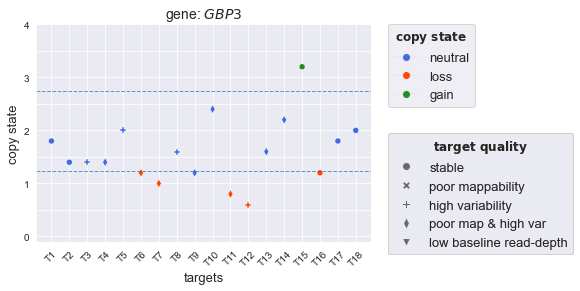

In [3]:
plot_gene('GBP3', ampliseq_table, mappability_table, Q1, Q3, IQR)

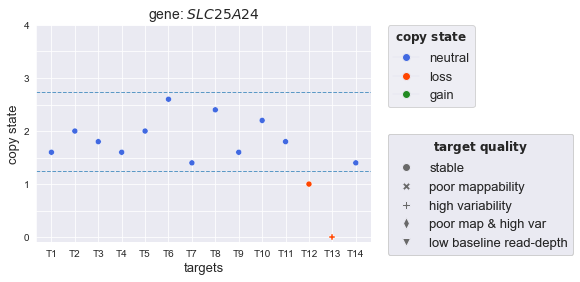

In [4]:
plot_gene('SLC25A24', ampliseq_table, mappability_table, Q1, Q3, IQR)

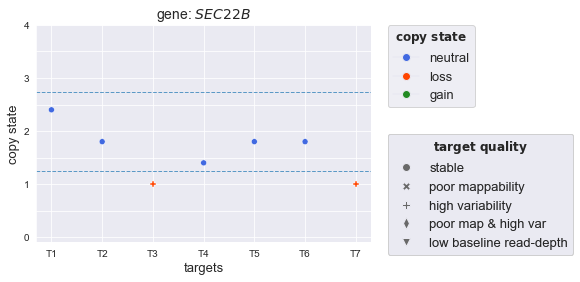

In [5]:
plot_gene('SEC22B', ampliseq_table, mappability_table, Q1, Q3, IQR)

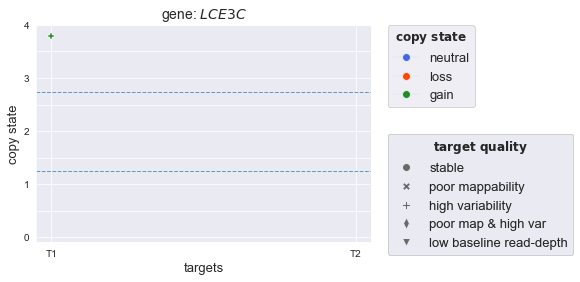

In [6]:
plot_gene('LCE3C', ampliseq_table, mappability_table, Q1, Q3, IQR)

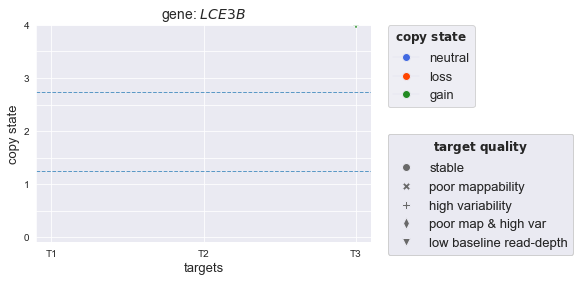

In [7]:
plot_gene('LCE3B', ampliseq_table, mappability_table, Q1, Q3, IQR)

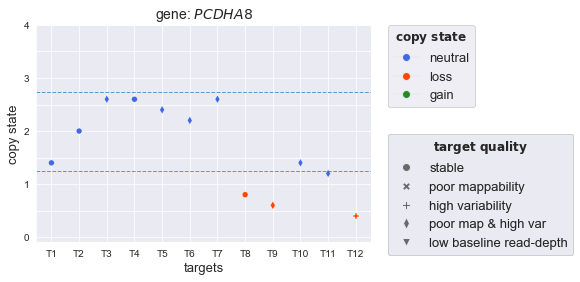

In [8]:
plot_gene('PCDHA8', ampliseq_table, mappability_table, Q1, Q3, IQR)

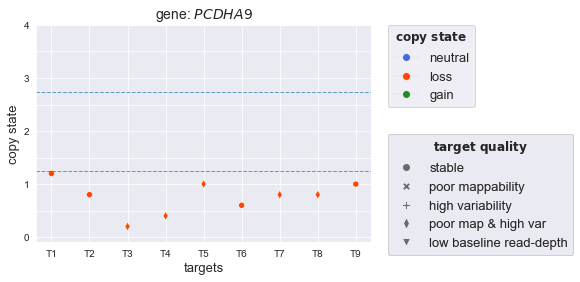

In [9]:
plot_gene('PCDHA9', ampliseq_table, mappability_table, Q1, Q3, IQR)

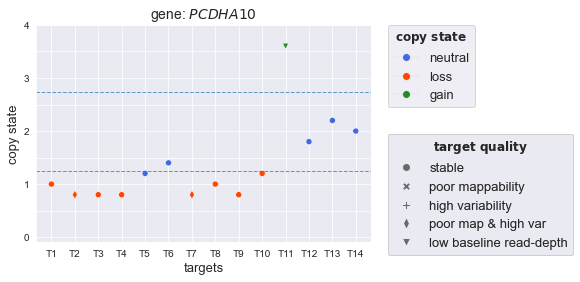

In [10]:
plot_gene('PCDHA10', ampliseq_table, mappability_table, Q1, Q3, IQR)

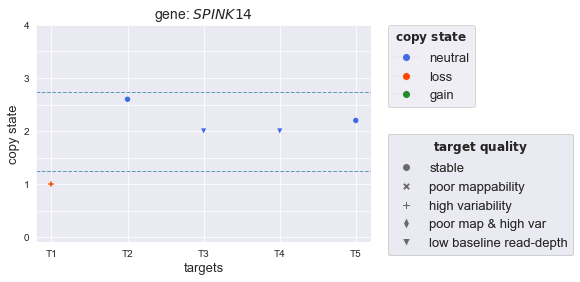

In [11]:
plot_gene('SPINK14', ampliseq_table, mappability_table, Q1, Q3, IQR)

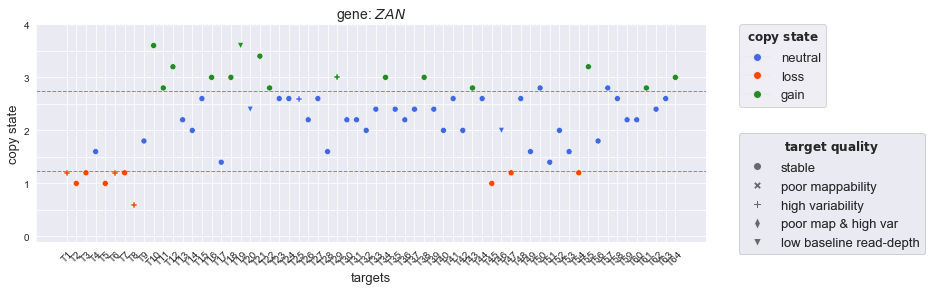

In [12]:
plot_gene('ZAN', ampliseq_table, mappability_table, Q1, Q3, IQR)

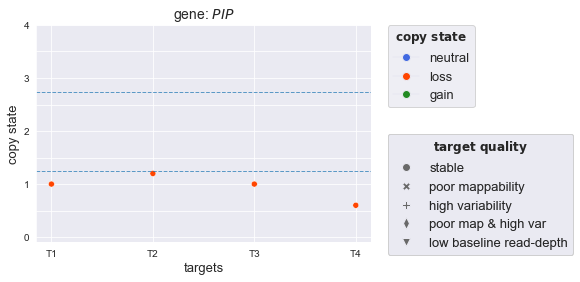

In [13]:
plot_gene('PIP', ampliseq_table, mappability_table, Q1, Q3, IQR)

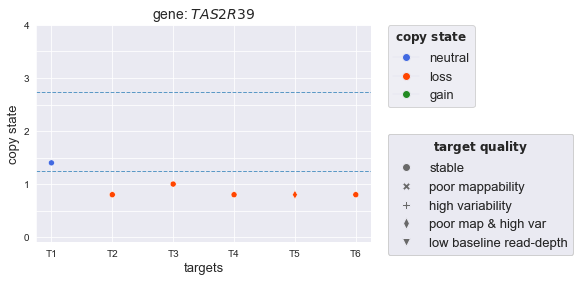

In [14]:
plot_gene('TAS2R39', ampliseq_table, mappability_table, Q1, Q3, IQR)

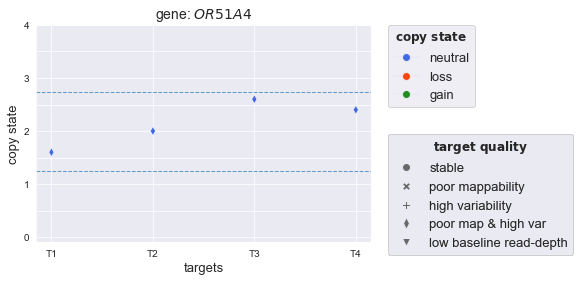

In [15]:
plot_gene('OR51A4', ampliseq_table, mappability_table, Q1, Q3, IQR)

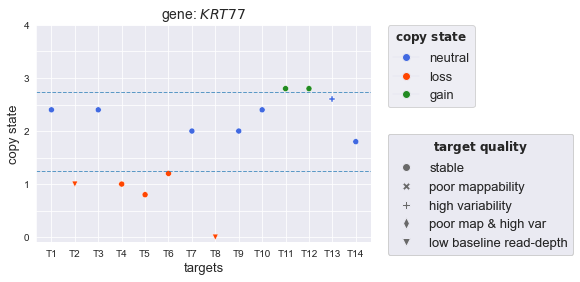

In [16]:
plot_gene('KRT77', ampliseq_table, mappability_table, Q1, Q3, IQR)

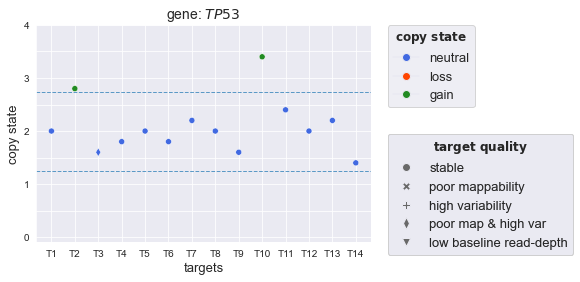

In [17]:
plot_gene('TP53', ampliseq_table, mappability_table, Q1, Q3, IQR)

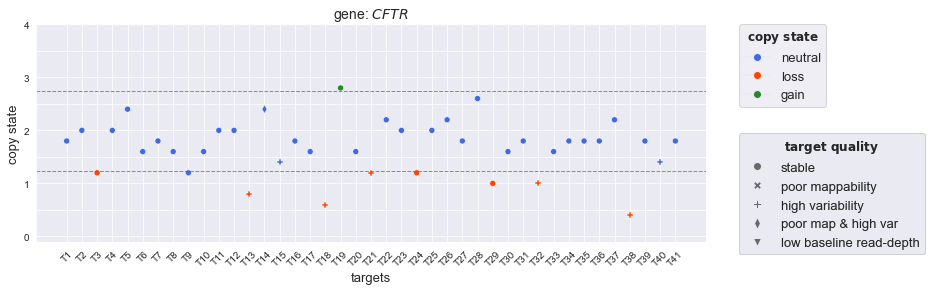

In [18]:
plot_gene('CFTR', ampliseq_table, mappability_table, Q1, Q3, IQR)